In [69]:
import os
import sys
from pathlib import Path

# Добавляем путь на уровень выше
sys.path.append(str(Path(os.getcwd()).resolve().parent))

from utils.features import *
from utils.graph_features import GraphClusterProcessor
from utils.load_data import load_all_data
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import pandas as pd
import numpy as np
from tabulate import tabulate


In [65]:
data_dir = Path('../data/PEMS-BAY')
metadata, data, adj = load_all_data(data_dir)
data = data[:2016]

In [ ]:
processor = GraphClusterProcessor(adj, data)
processor.elbow_method(metric='betweenness', max_clusters=15)

In [ ]:
labels = KMeans(n_clusters=6, random_state=42).fit_predict(
    np.array(list(nx.betweenness_centrality(nx.from_numpy_array(adj)).values())).reshape(-1, 1)
)

processor.plot_group_average_speeds(labels, n_clusters=6)

In [ ]:
# Добавление канала данных [..., C+1]
data_with_clusters = processor.cluster_and_add_channel(metric='betweenness', n_clusters=6)


In [25]:
data = data[:, :, 0]

In [22]:
adj = pd.DataFrame(adj)
data = pd.DataFrame(data)

In [ ]:
# Предположим, что данные начинаются с 00:00 понедельника
start_time = pd.Timestamp('2023-10-01 00:00:00')
time_index = pd.date_range(start=start_time, periods=2016, freq='5T')

df = pd.DataFrame(data, index=time_index)

# Фильтрация данных по времени
morning_data = df.between_time('06:00', '10:00')
evening_data = df.between_time('16:00', '22:00')

# Объединение данных с использованием pd.concat
filtered_df = pd.concat([morning_data, evening_data])

# Если нужно сохранить порядок временных меток
filtered_df = filtered_df.sort_index()

In [52]:
nodes = df[288:-288].mean(axis=0).sort_values()
slowest_node_indices = nodes.head(10).index.tolist()
fastest_node_indices = nodes.tail(10).index.tolist()


In [ ]:
np.fill_diagonal(adj, 0)
G = nx.from_numpy_array(adj)

# Находим все компоненты связности в графе
connected_components = list(nx.connected_components(G))
largest_component = max(connected_components, key=len)
G_cleaned = G.subgraph(largest_component).copy()

# Дополнительные характеристики узлов
degrees = dict(G_cleaned.degree())
betweenness_centrality = nx.betweenness_centrality(G_cleaned)
closeness_centrality = nx.closeness_centrality(G_cleaned)
pagerank = nx.pagerank(G_cleaned)  # PageRank
clustering_coefficient = nx.clustering(G_cleaned)  # Коэффициент кластеризации
core_number = nx.core_number(G_cleaned)  # Номер ядра
load_centrality = nx.load_centrality(G_cleaned)  # Нагрузочная центральность

# Функция для создания таблицы с характеристиками
def create_node_table(node_indices):
    return [
        [
            node,
            degrees[node],
            round(betweenness_centrality[node], 3),
            round(closeness_centrality[node], 3),
            # round(eigenvector_centrality[node], 3),
            round(pagerank[node], 3),
            round(clustering_coefficient[node], 3),
            core_number[node],
            round(load_centrality[node], 3)
        ]
        for node in node_indices
    ]

# Создаем таблицы для топ-10 медленных и быстрых узлов
slowest_nodes_table = create_node_table(slowest_node_indices)
fastest_nodes_table = create_node_table(fastest_node_indices)

# Выводим таблицы
headers = ["Узел", "Степень", "Посредн.", "Близость", "Собств. вектор", "PageRank", "Класт.", "Ядро", "Нагрузка"]
print("Топ-10 узлов с самыми низкими средними скоростями:")
print(tabulate(slowest_nodes_table, headers=headers, tablefmt="pretty"))

print("\nТоп-10 узлов с самыми высокими средними скоростями:")
print(tabulate(fastest_nodes_table, headers=headers, tablefmt="pretty"))


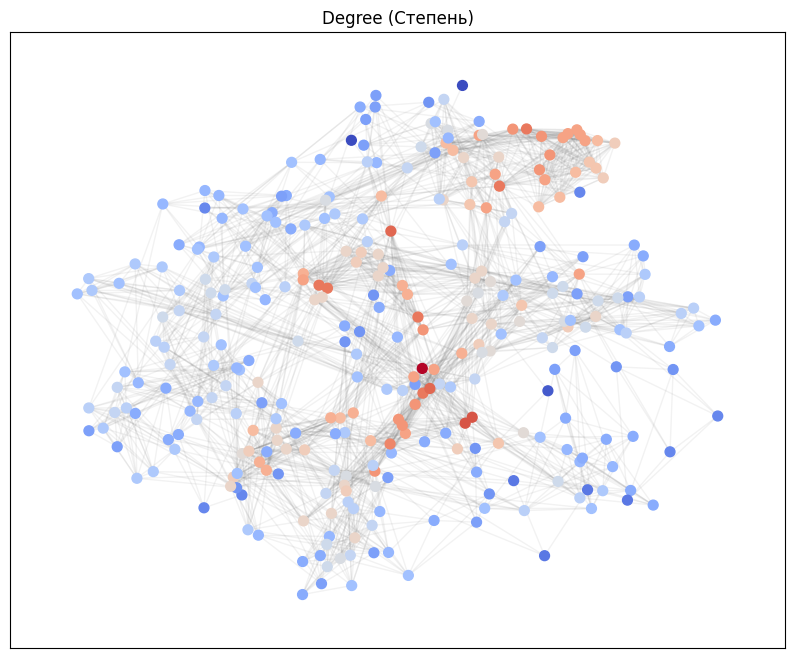

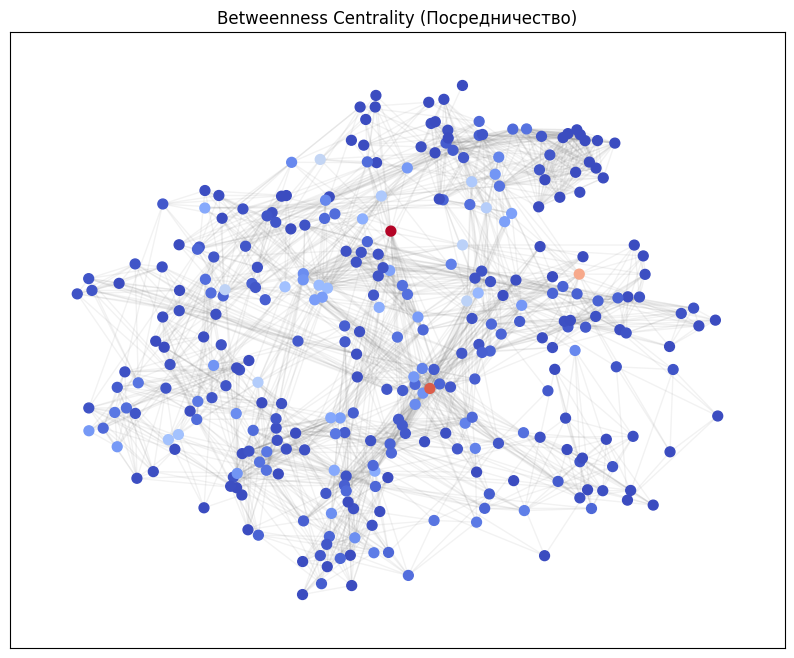

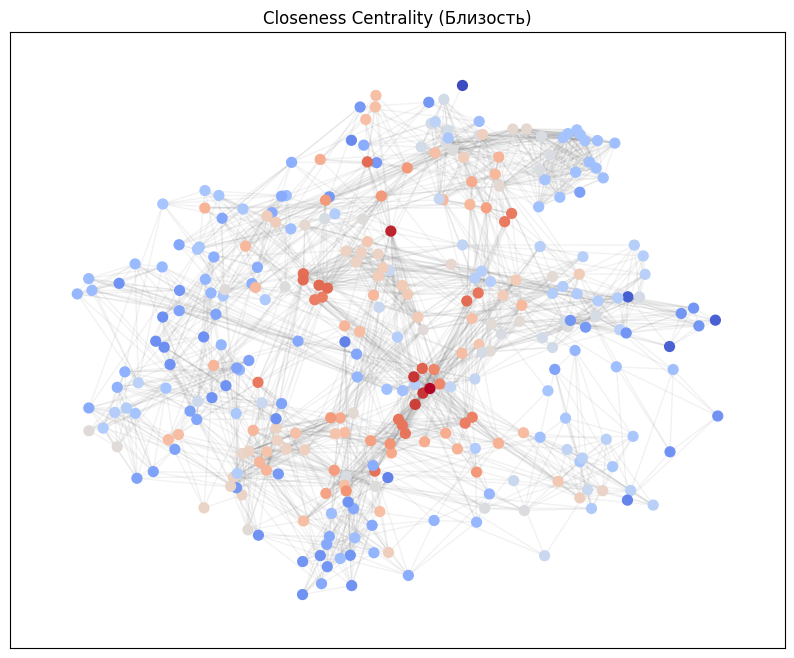

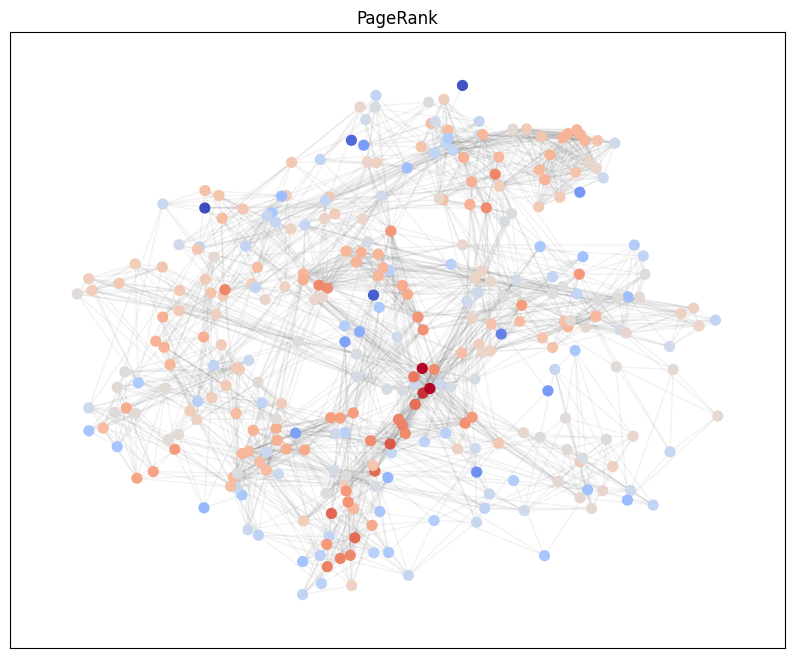

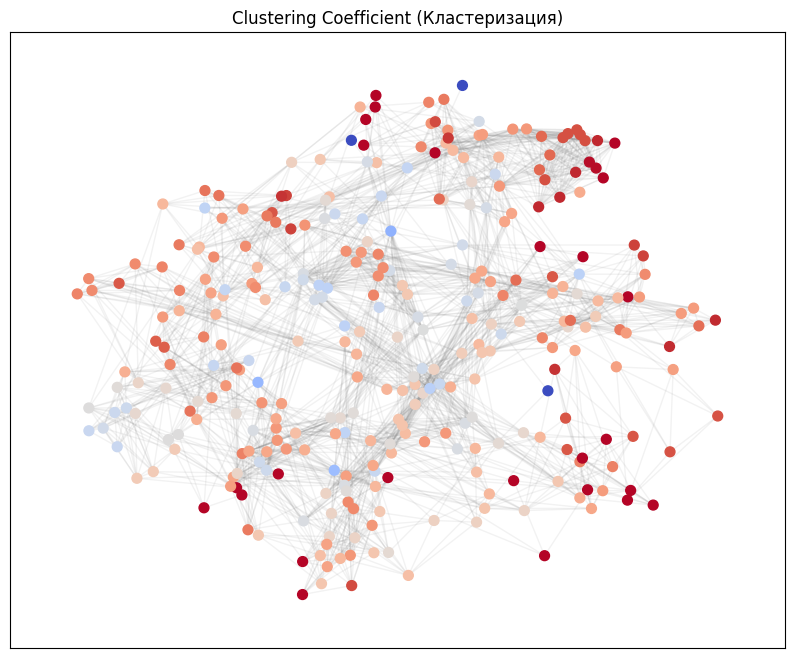

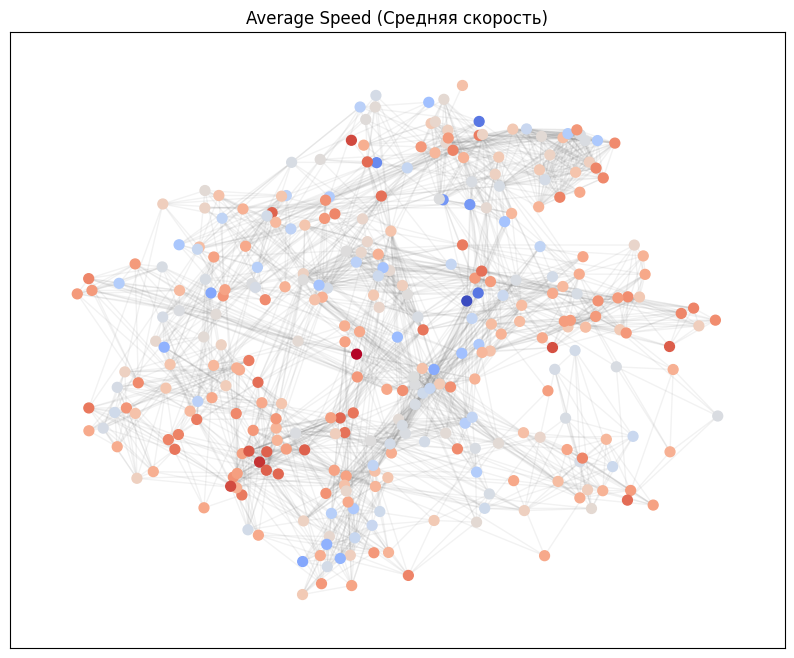

In [87]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors


# Загрузка координат узлов
node_coords = pd.read_csv("../data/PEMS-BAY/node_coordinates.csv")

# Преобразуем в словарь {node_id: (x, y)}
pos = {row.node_id: (row.x, row.y) for row in node_coords.itertuples(index=False)}

# Функция для отображения графа по разным характеристикам
def plot_graph_with_colors(G, values, title, cmap="coolwarm"):
    plt.figure(figsize=(10, 8))
    node_colors = np.array([values.get(node, 0) for node in G.nodes()])
    nx.draw_networkx_edges(G, pos, alpha=0.1, edge_color="gray")
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=cmap, node_size=50)
    
    plt.title(title)
    plt.show()

# Вычисление характеристик узлов
degrees = dict(G_cleaned.degree())
betweenness = nx.betweenness_centrality(G_cleaned)
closeness = nx.closeness_centrality(G_cleaned)
pagerank = nx.pagerank(G_cleaned)
clustering = nx.clustering(G_cleaned)
average_speeds = df[288:-288].mean(axis=0).to_dict()

# Визуализация графа с разными характеристиками
plot_graph_with_colors(G_cleaned, degrees, "Degree (Степень)")
plot_graph_with_colors(G_cleaned, betweenness, "Betweenness Centrality (Посредничество)")
plot_graph_with_colors(G_cleaned, closeness, "Closeness Centrality (Близость)")
plot_graph_with_colors(G_cleaned, pagerank, "PageRank")
plot_graph_with_colors(G_cleaned, clustering, "Clustering Coefficient (Кластеризация)")
plot_graph_with_colors(G_cleaned, average_speeds, "Average Speed (Средняя скорость)")


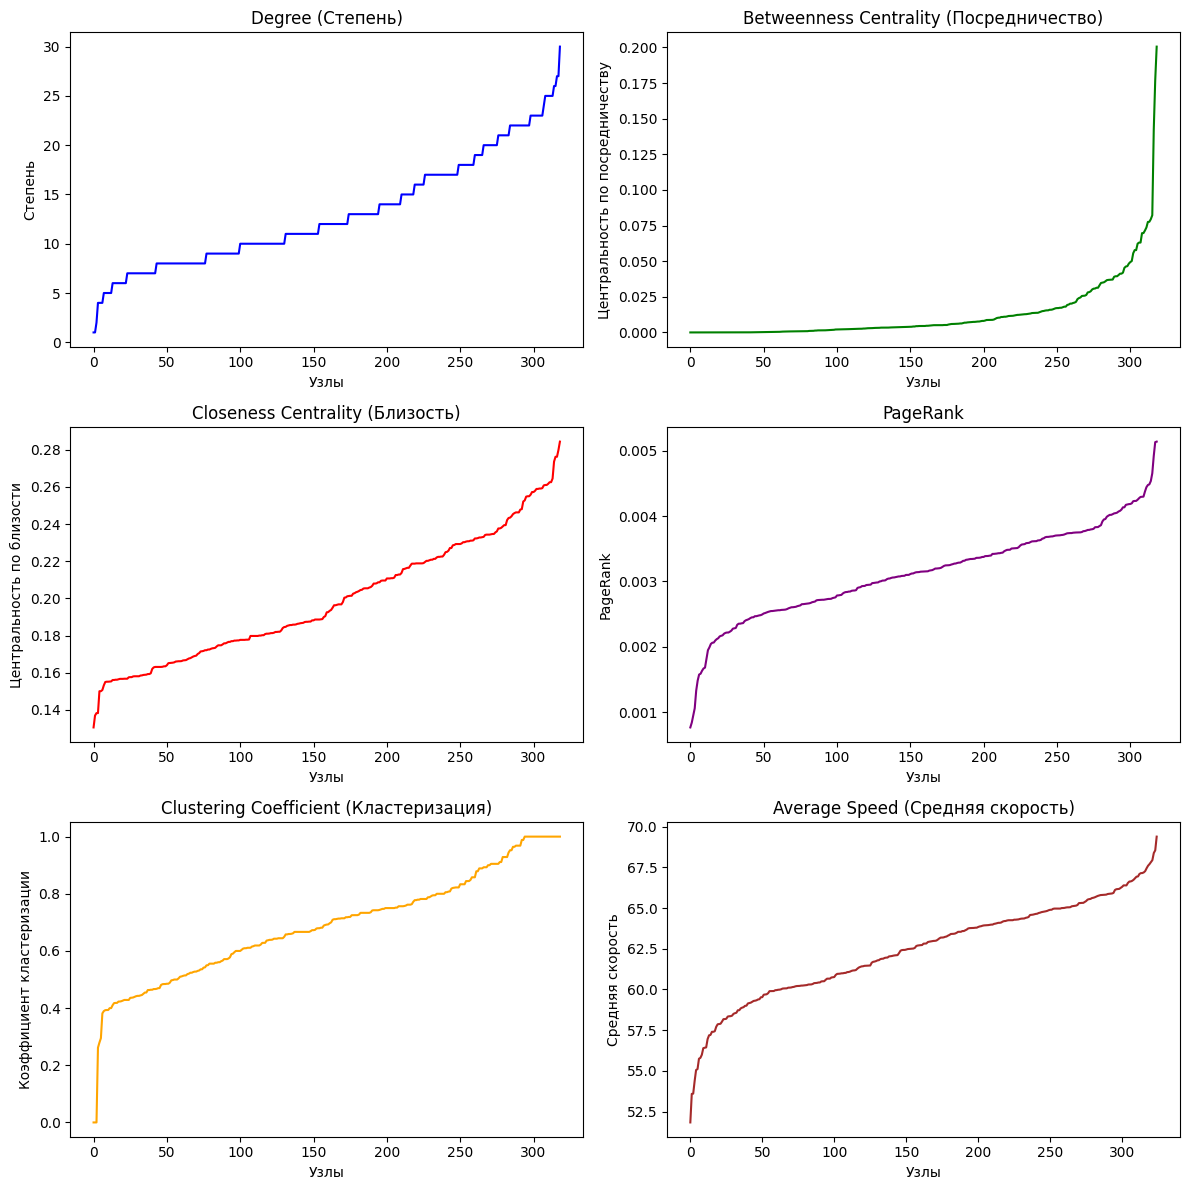

In [88]:

import matplotlib.pyplot as plt

# Сортировка характеристик по значениям
sorted_degrees = sorted(degrees.values())
sorted_betweenness = sorted(betweenness.values())
sorted_closeness = sorted(closeness.values())
sorted_pagerank = sorted(pagerank.values())
sorted_clustering = sorted(clustering.values())
sorted_avg_speeds = sorted(average_speeds.values())

# Создание подграфиков
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

# Степень узла
axes[0].plot(sorted_degrees, color='blue')
axes[0].set_title('Degree (Степень)')
axes[0].set_xlabel('Узлы')
axes[0].set_ylabel('Степень')

# Центральность по посредничеству
axes[1].plot(sorted_betweenness, color='green')
axes[1].set_title('Betweenness Centrality (Посредничество)')
axes[1].set_xlabel('Узлы')
axes[1].set_ylabel('Центральность по посредничеству')

# Центральность по близости
axes[2].plot(sorted_closeness, color='red')
axes[2].set_title('Closeness Centrality (Близость)')
axes[2].set_xlabel('Узлы')
axes[2].set_ylabel('Центральность по близости')

# PageRank
axes[3].plot(sorted_pagerank, color='purple')
axes[3].set_title('PageRank')
axes[3].set_xlabel('Узлы')
axes[3].set_ylabel('PageRank')

# Коэффициент кластеризации
axes[4].plot(sorted_clustering, color='orange')
axes[4].set_title('Clustering Coefficient (Кластеризация)')
axes[4].set_xlabel('Узлы')
axes[4].set_ylabel('Коэффициент кластеризации')

# Средняя скорость
axes[5].plot(sorted_avg_speeds, color='brown')
axes[5].set_title('Average Speed (Средняя скорость)')
axes[5].set_xlabel('Узлы')
axes[5].set_ylabel('Средняя скорость')

plt.tight_layout()
plt.show()


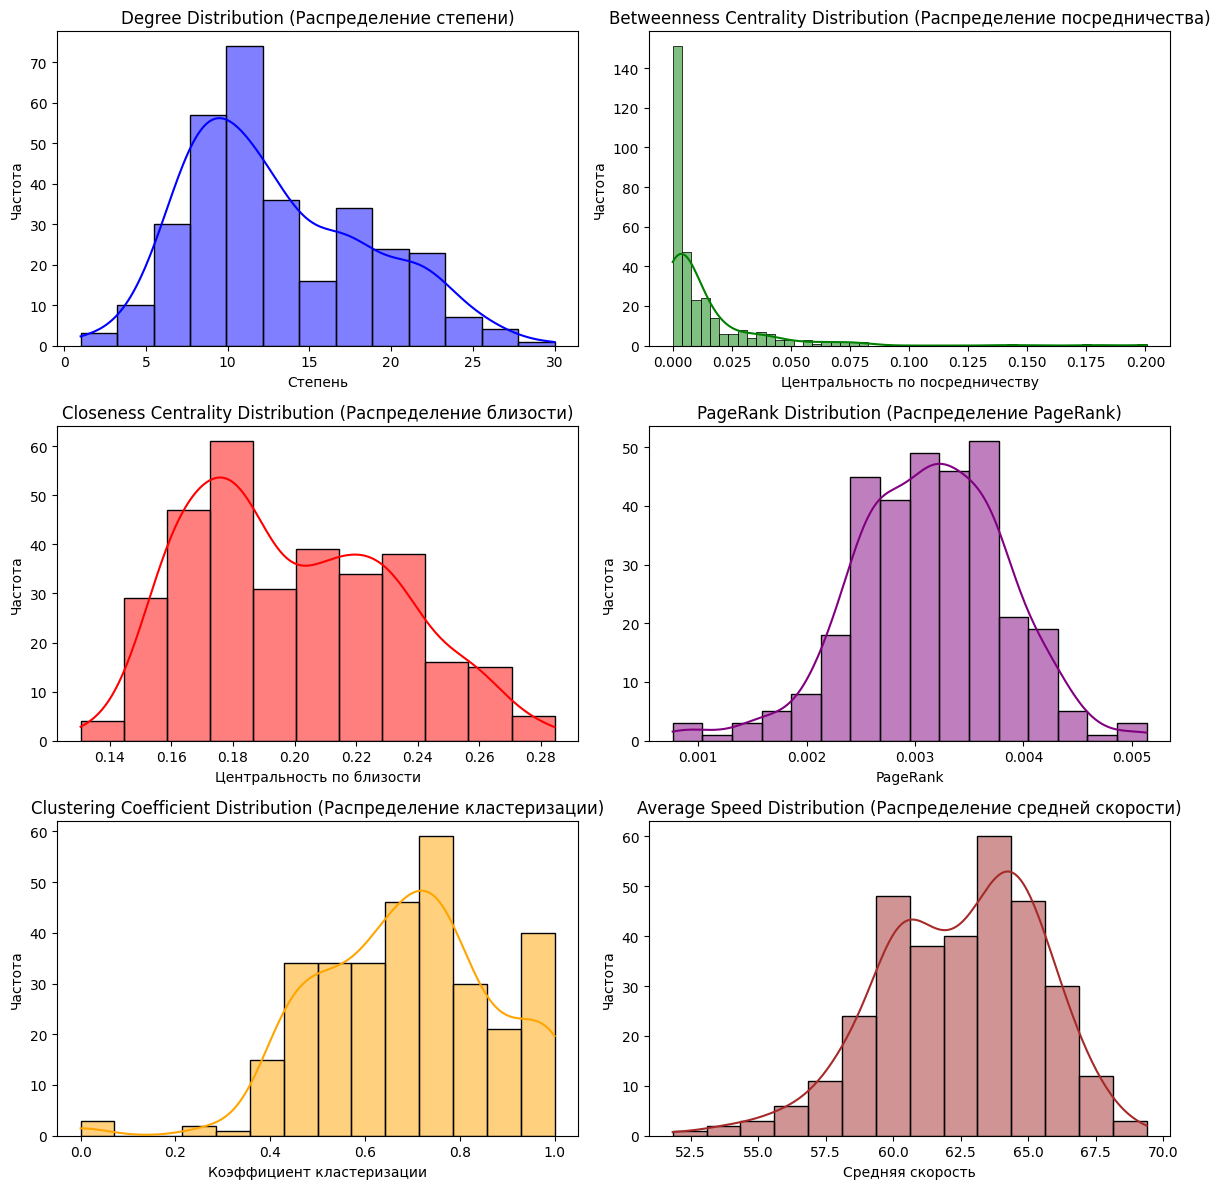

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

# Вычисление характеристик узлов
degrees = list(degrees.values())
betweenness = list(betweenness.values())
closeness = list(closeness.values())
pagerank = list(pagerank.values())
clustering = list(clustering.values())
average_speeds = list(average_speeds.values())

# Настройка графиков
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

# Степень узла
sns.histplot(degrees, kde=True, ax=axes[0], color='blue')
axes[0].set_title('Degree Distribution (Распределение степени)')
axes[0].set_xlabel('Степень')
axes[0].set_ylabel('Частота')

# Центральность по посредничеству
sns.histplot(betweenness, kde=True, ax=axes[1], color='green')
axes[1].set_title('Betweenness Centrality Distribution (Распределение посредничества)')
axes[1].set_xlabel('Центральность по посредничеству')
axes[1].set_ylabel('Частота')

# Центральность по близости
sns.histplot(closeness, kde=True, ax=axes[2], color='red')
axes[2].set_title('Closeness Centrality Distribution (Распределение близости)')
axes[2].set_xlabel('Центральность по близости')
axes[2].set_ylabel('Частота')

# PageRank
sns.histplot(pagerank, kde=True, ax=axes[3], color='purple')
axes[3].set_title('PageRank Distribution (Распределение PageRank)')
axes[3].set_xlabel('PageRank')
axes[3].set_ylabel('Частота')

# Коэффициент кластеризации
sns.histplot(clustering, kde=True, ax=axes[4], color='orange')
axes[4].set_title('Clustering Coefficient Distribution (Распределение кластеризации)')
axes[4].set_xlabel('Коэффициент кластеризации')
axes[4].set_ylabel('Частота')

# Средняя скорость
sns.histplot(average_speeds, kde=True, ax=axes[5], color='brown')
axes[5].set_title('Average Speed Distribution (Распределение средней скорости)')
axes[5].set_xlabel('Средняя скорость')
axes[5].set_ylabel('Частота')

plt.tight_layout()
plt.show()
